# 06. PyTorch Transfer Learning

https://www.learnpytorch.io/06_pytorch_transfer_learning/

## Table of Contents

- [All Links in Document](#links)
- [PyTorch Transfer Learning](#transfer)
- [Loading and Preparing Data](#loadprep)
- [Building a Pretrained Model](#buildmodel)
- [Training a Pretrained Model](#trainmodel)
- [Evaluation](#eval)

## All Links in Document <a name="links" />

- https://developers.google.com/machine-learning/glossary#transfer-learning
- https://arxiv.org/abs/2106.10270
- https://pytorch.org/vision/stable/models
- https://pytorch.org/text/main/models
- https://pytorch.org/audio/stable/models
- https://huggingface.co/models
- https://huggingface.co/datasets
- https://github.com/huggingface/pytorch-image-models
- https://paperswithcode.com/
- https://pytorch.org/vision/0.12/models
- https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101
- https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0
- https://developers.google.com/machine-learning/glossary#dropout_regularization

## PyTorch Transfer Learning <a name="transfer" />

In [1]:
# Imports
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from typing import List, Tuple
import random

# Helper functions
from helper_functions import plot_loss_curves

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu117
0.14.1+cu117


*NOTE: torch version should be 1.12 or higher and torchvision version should be 0.13 or higher to work with APIs for this Notebook.*

Several models were built from scratch in the previous Notebooks thus far, using toy datasets as well as custom datasets, and training them from scratch. Some of the models produced adequate results while others struggled to work properly. With limited options and resources, it's no wonder that performance may be lacking.

For most use cases, it's likely that a well-performing model already exists. If they are made public, it's possible to utilize them and train them even further for your own specific problem. This is referred to as **transfer learning**. Transfer learning might involve transferring knowledge from the solution of a simpler task to a more complex one, or involve transferring knowledge from a task where there is more data to one where there is less data. Most machine learning systems solve a single task. Transfer learning is a baby step towards artificial intelligence in which a single program can solve multiple tasks.

https://developers.google.com/machine-learning/glossary#transfer-learning

Transfer learning allows for the taking of patterns (also called weights) that another model has learned from another problem and use them for a different problem. For example, it's possible to take the weights of a model that has learned from an image database such as ImageNet (https://www.image-net.org/), and use them to power a custom food classification model.

While the specifics may differ per problem, the principle remains the same: finding a well-performing, existing model and applying it to your own problem.

<img src="images/06_transfer_learning.png" />

The above image shows the computer vision example of taking weights from a mode that is trained on ImageNet data, as well as a second example of a Natural Language Processing problem. The second problem illustrates that the principle can be applied in all sorts of situations, and not just for image classification tasks. Tasks such as classifying e-mails as spam have been explored by many companies and individuals. It's thus likely that a model exists to use as basis for the purpose of transfer learning.

There are two main benefits to using transfer learning:
- It's possible to leverage an existing model (usually a neural network architecture) proven to work on problems similar to your own.
- It's possible to leverage a working model which has already learned patterns on similar data to your own. This often results in achieving great results with less custom data.

<img src="images/06_transfer_learning_flow.png" />

The practice of transfer learning is supported by both research and practice. An excerpt from How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers, by (https://arxiv.org/abs/2106.10270) states:

<img src="images/06_transfer_learning_conclusion.png" />

There are several locations where such pretrained models can be found, depending on the problem space. Each of the PyTorch domains (torchvision, torchtext, torchaudio, etc.) comes with pretrained models that are directly compatible with PyTorch. These models can be found in their respective domain's PyTorch docs:

- https://pytorch.org/vision/stable/models
- https://pytorch.org/text/main/models
- https://pytorch.org/audio/stable/models

The website HuggingFace focuses contains pretrained models for various domains (vision, text, audio, and more), but mainly focuses on Transformer-type models. In addition, the website contains datasets for specific problem spaces as well. These models and datasets are found at:

- https://huggingface.co/models
- https://huggingface.co/datasets

Another useful source is TIMM (PyTorch Image Models Library) which contains almost all of the latest and greatest computer vision in PyTorch code, as well as a plethora of other useful computer vision features.

- https://github.com/huggingface/pytorch-image-models

The Papers with Code website (earlier used to determine that PyTorch is very trendy nowadays) contains a collection of the latest state-of-the-art machine learning papers with code implementations attached, as well as benchmarks of model performance on different tasks.

- https://paperswithcode.com/

## Loading and Preparing Data <a name="loadprep" />

In [3]:
# Setting up data paths
IMAGE_PATH = Path("data/PizzaSteakSushi")
TRAIN_DIR = Path(f"{IMAGE_PATH}/train")
TEST_DIR = Path(f"{IMAGE_PATH}/test")

After setting up the data paths, dataset creation and dataloader creation are up next. The same PizzaSteakSushi dataset will be utilized once again. However, as a pretrained model from `torchvision.models` is intended to be used, it's necessary to prepare a specific transform. When using a pretrained model, it's important that custom data going into the model is prepared in the same way as the original training data that went into the model. There are two ways to go about this:

- Manual creation
- Automatic creation

#### Manual Creation

Prior to `torchvision` version 0.13 or higher, manual creation was necessary. While a newer and more efficient method (automatic creation) now exists, it's still useful to explore how manual creation was done to understand the underlying concepts. The `torchvision.models` documentation prior to version 0.13 (https://pytorch.org/vision/0.12/models) stated the following:

*"All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:"*

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

The above requirements can be achieved through a series of transforms, which are:

- Create mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224 or bigger
- Adjust values to be between 0 and 1
- Adjust for a mean of `[0.485, 0.456, 0.406]` (values across each colour channel)
- Adjust for a standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel)

The very first step can be achieved by utilizing `torchvision.transforms.Resize()` to adjust image dimensions, and by using `torch.utils.data.DataLoader()` to create batches of images. The second step is achieved by a simple `torchvision.transforms.ToTensor()` function. The final two steps can be achieved with `torchvision.transforms.Normalize(mean=..., std=...)` to adjust the mean and the standard deviation of the images.

*NOTE: some pretrained models from `torchvision.models` require sizes different from `[3, 224, 224]`. For example, some might require a size such as `[3, 240, 240]`. For specific input image sizes, see the documentation of said model.*

But where exactly do these values for the mean and standard deviation transforms come from? These values were calculated from the ImageNet dataset by taking the means and standard deviations across a subset of images. An example of such a normalization can be found in the imagenet example here: https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101.
It's not 100% necessary to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help the network achieve better performance quicker.

In [5]:
# Collection of required transforms discussed above
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

The creation of batches is handled by the usual creation of datasets and dataloaders, incorporating this transform to complete the whole process.

In [6]:
# Creation of datasets using the special transforms
train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=manual_transform)
test_data = datasets.ImageFolder(root=TEST_DIR, transform=manual_transform)

In [7]:
# Creation of dataloaders and a class names variable
train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=os.cpu_count(), shuffle=False)
class_names = train_data.classes

#### Automatic Creation

As previously stated, as of `torchvision` version 0.13 and higher, it's possible to automatically create the necessary transform for the usage of pretrained models. An example of how to do this is:

In [8]:
# Fetching a pretrained model's weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights, type(weights)

(EfficientNet_B0_Weights.IMAGENET1K_V1, <enum 'EfficientNet_B0_Weights'>)

Here, `EfficientNet_B0_Weights` is the model architecture of which the weights will be taken. This is just 1 example and there are many more options available in `torchvision.models` to take weights from. The `DEFAULT` portion of the code refers to the best available weights (best performance in ImageNet). When deciding on which model architecture to take weights from, it's common to run into version numbers such as `IMAGENET_V1` and `IMAGENET_V2`. Generally, the higher numbered version is better, but `DEFAULT` is an easy shortcut to acquiring the best weights.

After importing these weights, it's now possible to access the associated transforms that were used by calling the `transforms()` method. This is essentially saying "get the data transforms that were used to train the `EfficientNet_B0_Weights` on ImageNet".

In [9]:
# Fetching the weights' associated transforms
auto_transforms = weights.transforms()
auto_transforms, type(auto_transforms)

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 torchvision.transforms._presets.ImageClassification)

Notice that the transforms are very similar to the transforms that were manually created earlier on. The benefit of automatically creating the transforms like this is a guarantee that the exact same transforms are utilized as when the pretrained model was trained. The tradeoff, however, is a lack of customization.

The datasets and dataloaders can now be remade by using this new collection of transforms.

In [10]:
# Creation of datasets using the automatic transforms
train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=auto_transforms)
test_data = datasets.ImageFolder(root=TEST_DIR, transform=auto_transforms)

In [11]:
# Creation of dataloaders using the automatic transforms and a class names variable
train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=os.cpu_count(), shuffle=False)

## Building a Pretrained Model <a name="buildmodel" />

Recall that the whole idea of transfer learning is to take an already well-performing model for a problem-space similar to yours and then customising it to your use case. The intent is to improve upon any results from working with the PizzaSteakSushi dataset. As the focus is still on image classification, `torchvision.models` is the right place to be.

Exploring the https://pytorch.org/vision/stable/models documentation shows plenty of common computer vision architectures such as:

<img src="images/06_pretrained_examples.png" />

Generally, the higher the model version number, the better the performance of that model. However, it usually also means an increase in size. It's likely that some of these models are too large to run on some devices, depending on specs. For that reason, the choice between performance and size always remains a tradeoff to consider.

The pretrained model to experiment with for this Notebook will be `torchvision.models.efficientnet_b0` (note the lowercase spelling here). The docs for this model can be found here: https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0

<img src="images/06_efficientnetb0.png" />

The above image shows an example of what's going to be created: a pretrained `EfficientNetB0` model from `torchvision.models` with an adjusted output layer for pizza, steak, and sushi.

In [12]:
# Creating weights and the model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

*NOTE: The above method of setting up a model with pretrained weights is preferred as of `torchvision` version 0.13. Prior to version 0.13, setting up the model with pretrained weights would be performed with code such as `model = torchvision.models.efficientnet_b0(pretrained=True)`.*

<img src="images/06_efficientnetb0_model.png" />

The above shows an excerpt of the model, with some layers cut out as it's quite large. The image shows that the `efficientnet_b0` model consists of 3 main parts, which are:

- `features`: A collection of convolutional layers and other activation layers to learn a base representation of vision data. This base representation/collection of layers is often referred to as features or feature extractor.
- `avgpool`: Takes the average of the output of the `features` layers and turns it into a feature vector.
- `classifier`: Turns the feature vector into a vector with the same dimensionality as the number of required output classes (since efficientnet_b0 is pretrained on ImageNet and because ImageNet has 1000 classes, out_features=1000 is the default).

A summary of the model can be explored with `torchinfo.summary`.

In [13]:
# Creating model summary
summary(model=model, 
        input_size=[32, 3, 244, 244], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=19,
        device="cpu")

Layer (type:depth-idx)                                  Input Shape         Output Shape        Param #             Trainable
EfficientNet                                            [32, 3, 244, 244]   [32, 1000]          --                  True
├─Sequential: 1-1                                       [32, 3, 244, 244]   [32, 1280, 8, 8]    --                  True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 244, 244]   [32, 32, 122, 122]  --                  True
│    │    └─Conv2d: 3-1                                 [32, 3, 244, 244]   [32, 32, 122, 122]  864                 True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 122, 122]  [32, 32, 122, 122]  64                  True
│    │    └─SiLU: 3-3                                   [32, 32, 122, 122]  [32, 32, 122, 122]  --                  --
│    └─Sequential: 2-2                                  [32, 32, 122, 122]  [32, 16, 122, 122]  --                  True
│    │    └─MBConv: 3-4      

The summary shows that this model is much larger than any manually created model thus far. For example, the custom TinyVGG model had 8,083 parameters. This model has 5,288,548 total parameters to work with.

Currently, the `efficientnet_b0` model has 1000 classes in its output layer (the classifier), whereas the PizzaSteakSushi dataset only cares about 3 of them. Using a pretrained model usually requires for changes in the output layer, but for the rest of the model to remain the same. It's possible to do this by **freezing** the `features` section of this model. This essentially means to retain the state certain layers are in during the training process, leaving them unchanged.

It's possible to do this by setting the `requires_grad` attribute of the model's `features` section to False.

In [14]:
# Freezing all features
for param in model.features.parameters():
    param.requires_grad = False

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates. In turn, these parameters won't be changed by the optimizer during training.

It's possible to change the classifier layer by recreating it with adjusted values, and overriding the original classifier layer by assigning the new one to the model.

In [15]:
# Inspecting the classifier layer
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

*NOTE: The Dropout layer will be kept as well. Dropout layer information: https://developers.google.com/machine-learning/glossary#dropout_regularization.*

In [16]:
torch.manual_seed(42)
output_shape = len(class_names)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
)

In [17]:
# Inspecting the classifier layer again
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

It's possible to gather more information again with another summary.

In [18]:
# Creating model summary
summary(model=model, 
        input_size=[32, 3, 244, 244], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=19,
        device="cpu")

Layer (type:depth-idx)                                  Input Shape         Output Shape        Param #             Trainable
EfficientNet                                            [32, 3, 244, 244]   [32, 3]             --                  Partial
├─Sequential: 1-1                                       [32, 3, 244, 244]   [32, 1280, 8, 8]    --                  False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 244, 244]   [32, 32, 122, 122]  --                  False
│    │    └─Conv2d: 3-1                                 [32, 3, 244, 244]   [32, 32, 122, 122]  (864)               False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 122, 122]  [32, 32, 122, 122]  (64)                False
│    │    └─SiLU: 3-3                                   [32, 32, 122, 122]  [32, 32, 122, 122]  --                  --
│    └─Sequential: 2-2                                  [32, 32, 122, 122]  [32, 16, 122, 122]  --                  False
│    │    └─MBConv: 3

Several changes have taken place after adjusting the classifier layer of the model, these have taken place in the following places:

- Trainable column: Many values within this column have been set to False, whereas they were True before. This is the result of setting `requires_grad` to False. These layers won't be updated during training as long as this is the case.
- Output shape of the classifier: The classifier now has an output shape of `[32, 3]` instead of `[32, 1000]`. It also has a value of True in the Trainable column. This means its parameters will be updated during training.
- Fewer trainable parameters: previously, there were 5,288,548 trainable parameters, which has been reduced to 3,843. This is less than the custom TinyVGG model, but there are also 4,007,548 non-trainable parameters, these will create a base representation of the input images to feed into the classifier layer.

*NOTE: The more trainable parameters a model has, the more compute power/longer it takes to train. Freezing the base layers of the model and leaving it with fewer trainable parameters means the model should train quite quickly. This is another benefit of transfer learning.*

## Training a Pretrained Model <a name="trainmodel" />

The creation of a loss function, optimizer, and optional metric is once again required.

In [19]:
# Creation of loss function, optimizer, and metric
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
metric_fn = Accuracy(task="multiclass", num_classes=len(class_names))

In [20]:
# Manually written code for more practice!
# It's also possible to use the train.py script found in the modular_scripts folder
torch.manual_seed(42)
EPOCHS = 5

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(EPOCHS):
    train_loss, train_acc = 0, 0
    test_loss, test_acc = 0, 0
    
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += metric_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
        
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model(X)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss += loss_fn(test_logits, y)
            test_acc += metric_fn(test_pred, y)
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    results["train_loss"].append(train_loss.detach())
    results["train_acc"].append(train_acc.detach())
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

Epoch: 0 | Train Loss: 1.09660, Train Acc: 0.39 | Test Loss: 0.88426, Test Acc: 0.68
Epoch: 1 | Train Loss: 0.91920, Train Acc: 0.65 | Test Loss: 0.79140, Test Acc: 0.83
Epoch: 2 | Train Loss: 0.75420, Train Acc: 0.87 | Test Loss: 0.64835, Test Acc: 0.92
Epoch: 3 | Train Loss: 0.73778, Train Acc: 0.71 | Test Loss: 0.59653, Test Acc: 0.90
Epoch: 4 | Train Loss: 0.62679, Train Acc: 0.76 | Test Loss: 0.61267, Test Acc: 0.90


The results show a massive reduction in loss and increase in accuracy compared to the custom TinyVGG model results from previous Notebooks. Usage of the `efficientnet_b0` architecture is a clear improvement, and it supports the initial statement that transfer learning is a useful method to quickly achieve good results. It only took a few lines of code to import a model and set up the necessary transforms. Comparatively, the increase in performance for the amount of effort is much higher than any previously attempted solution thus far.

## Evaluation <a name="eval" />

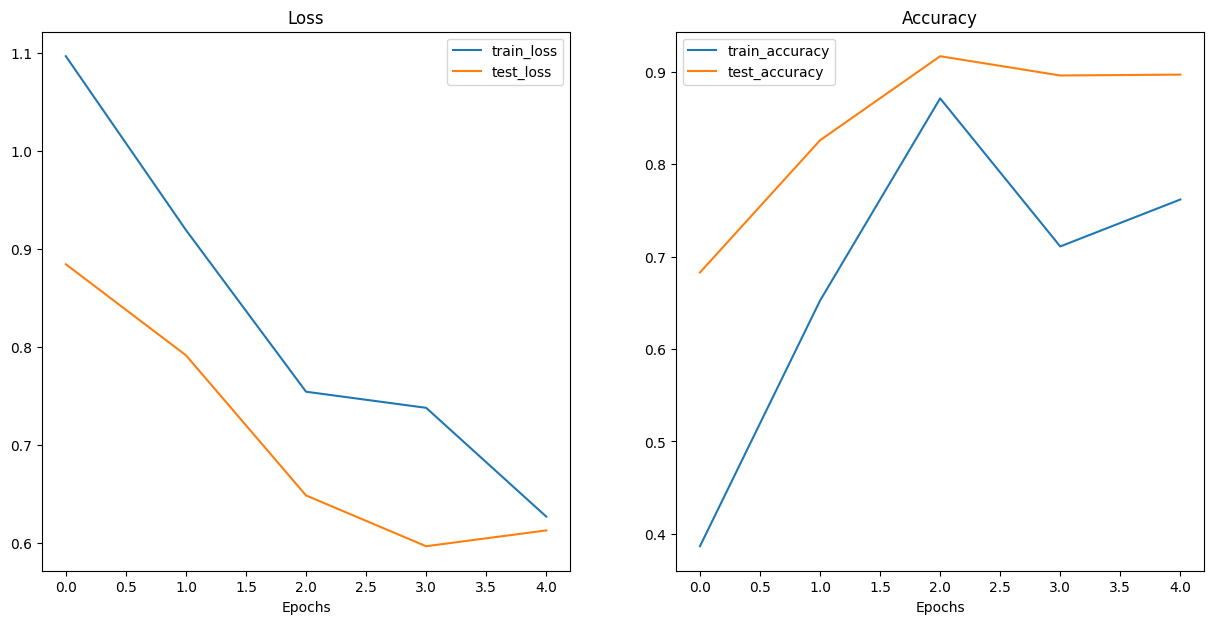

In [21]:
# Plotting loss curves with a helper function
plot_loss_curves(results)

These loss curves paint a positive picture, visually confirming the earlier conclusion. The loss is decreasing over time and the accuracy shoots up. This is a major improvement compared to the loss curves of any custom TinyVGG model results that were created in previous Notebooks. 

It's now possible to make predictions on images from the test set, but there are several requirements that need to be satisfied. The testing images need to have the same:

- Shape: Shape errors will occur if images do not have the same dimensions as the training images
- Data type: Data type errors will occur if the images do not have the same data type (e.g., `torch.int8` vs `torch.float32`)
- Device: Device errors will occur if images are on a different device than the model's device
- Transformations: Making predictions on images that are transformed in a different way than the training images may cause results to be off.

In short, it's important to stick to the same format. This is the case no matter the type of data.

In [22]:
# Making a prediction function
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    transform: torchvision.transforms
) -> None:
    
    img = torchvision.io.read_image(str(image_path)).type(torch.float32)
    model.eval()
    with torch.inference_mode():
        transformed_img = transform(img).unsqueeze(dim=0)
        pred_logits = model(transformed_img)
        pred_probs = torch.softmax(pred_logits, dim=1)
        pred_label = torch.argmax(pred_probs, dim=1)
        
        plt.figure()
        plt.imshow(img.permute(1, 2, 0)/255)
        plt.title(f"Pred: {class_names[pred_label]} | Prob: {pred_probs.max():.3f}")
        plt.axis(False);

In [23]:
# Collecting 5 random custom image paths
img_count = 5
img_paths = list(Path(TEST_DIR).glob("*/*.jpg"))
img_sample = random.sample(img_paths, img_count)

In [24]:
img_sample

[WindowsPath('data/PizzaSteakSushi/test/pizza/344397.jpg'),
 WindowsPath('data/PizzaSteakSushi/test/sushi/1434806.jpg'),
 WindowsPath('data/PizzaSteakSushi/test/sushi/3177743.jpg'),
 WindowsPath('data/PizzaSteakSushi/test/steak/673127.jpg'),
 WindowsPath('data/PizzaSteakSushi/test/steak/1882831.jpg')]

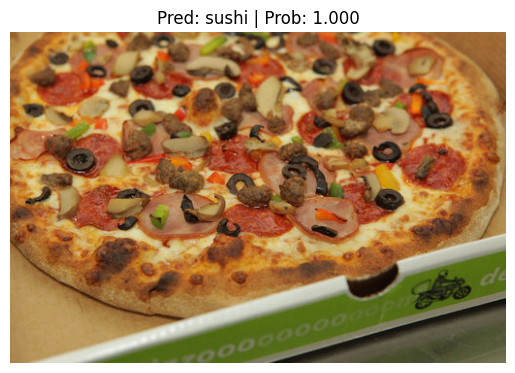

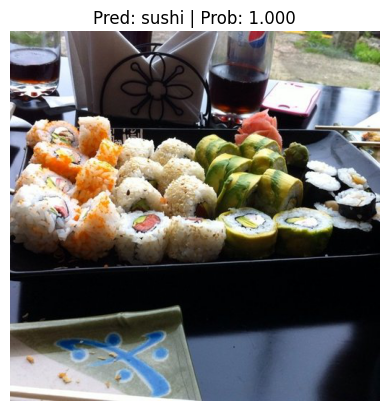

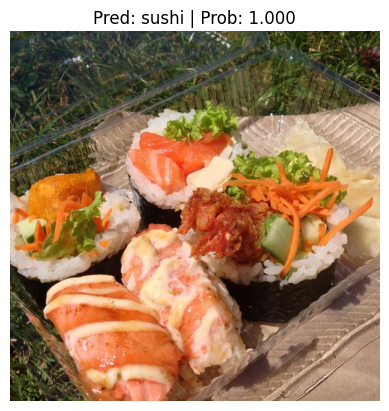

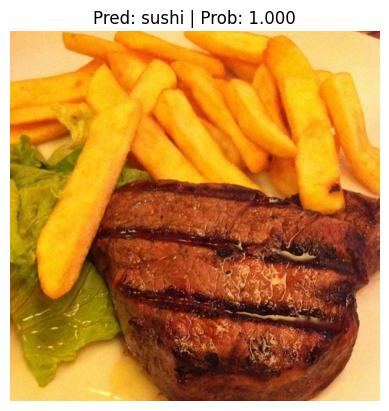

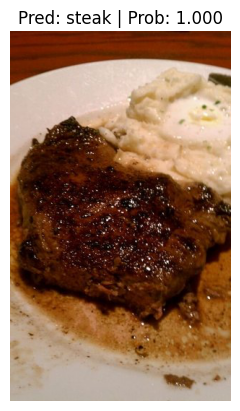

In [25]:
for i in img_sample:
    pred_and_plot_image(model, i, class_names, auto_transforms)

it's visible that the model doesn't always predict the right class. Admittedly, the images in the PizzaSteakSushi dataset are of poor quality and they contain plenty of errors (such as an image of a burger and fries in the pizza testing dataset). However, the training results and loss curves already show a great increase compared to any previous models. While more improvement is possible, the power of transfer learning has become known.

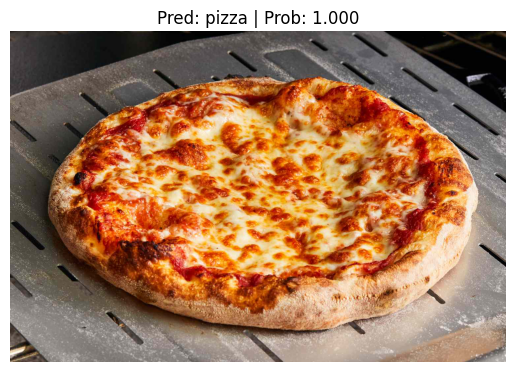

In [26]:
# Predicting a custom image's class
custom_pizza = Path(f"images/04_pizza.jpg")
pred_and_plot_image(model, custom_pizza, class_names, auto_transforms)

Main transfer learning takeaways:

- Transfer learning often allows to get good results with a relatively small amount of custom data
- It's a good idea to ask at the start of every problem, "does an existing well-performing model exist for my problem?". If so, transfer learning could be useful
- When using a pretrained model, it's important that custom data is formatted/preprocessed in the same way as data that the original model was trained on, otherwise performance may suffer
- The same goes for predicting on custom data, ensure that custom data is in the same format as the data the model was trained on
- There are several different places to find pretrained models from the PyTorch domain libraries, HuggingFace Hub and libraries such as timm (PyTorch Image Models)